# Assignment 4

In [0]:

import pandas as pd
import numpy as np
import datetime
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
 

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from os import listdir
from os.path import isfile, join
from PIL import Image

path = '/content/gdrive/My Drive/Colab Notebooks/input/JPEGImages'

imagesPaths = [f for f in listdir(path) if isfile(join(path, f))]

### Uploading the images and creating the dataset in sizes: 72x72, 144x144, 288x288

In [0]:
from matplotlib.pyplot import imshow

X = []
Y_mid = []
Y_large = []

for imagePath in imagesPaths[:50]:
    image = Image.open(join(path,imagePath),'r')
    X.append(np.asarray(image.resize((72,72), Image.ANTIALIAS)))
    Y_mid.append(np.asarray(image.resize((144,144), Image.ANTIALIAS)))
    Y_large.append(np.asarray(image.resize((288,288), Image.ANTIALIAS)))

In [0]:
X = np.asarray(X)
Y_mid = np.asarray(Y_mid)
Y_large = np.asarray(Y_large)

In [6]:
print(X.shape)
print(Y_mid.shape)
print(Y_large.shape)


(50, 72, 72, 3)
(50, 144, 144, 3)
(50, 288, 288, 3)


### Train-Test-Split

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_val,Y_mid_train, Y_mid_val,Y_large_train, Y_large_val = train_test_split(X,Y_mid,Y_large, test_size=0.2)


In [8]:
print(X_train.shape)
print(X_val.shape)
print(Y_mid_train.shape)
print(Y_mid_val.shape)
print(Y_large_train.shape)
print(Y_large_val.shape)

(40, 72, 72, 3)
(10, 72, 72, 3)
(40, 144, 144, 3)
(10, 144, 144, 3)
(40, 288, 288, 3)
(10, 288, 288, 3)


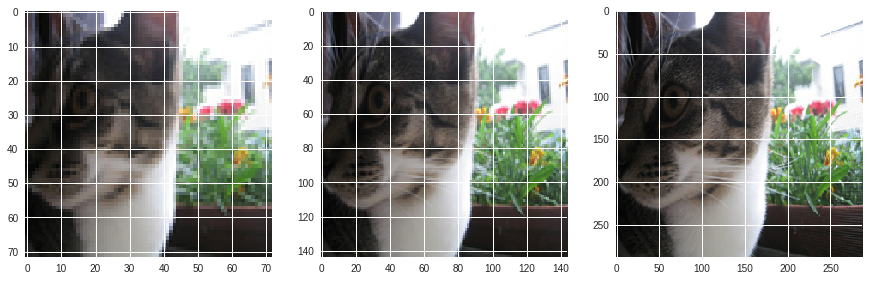

In [9]:
fig=plt.figure(figsize=(15, 15))

fig.add_subplot(1, 3, 1)
plt.imshow(X[1])
fig.add_subplot(1, 3, 2)
plt.imshow(Y_mid[1])
fig.add_subplot(1, 3, 3)
plt.imshow(Y_large[1])
plt.show()

In [10]:
from keras.models import Model,Sequential
from keras.layers import * # Dense, Embedding, LSTM
from keras.applications import VGG16

Using TensorFlow backend.


## Resnet block

Before we create the initial model, we will define the Resnet Block which will use later to enhance the model.

In [0]:
def resnetBlock():
    inp = Input(shape=(None,None,64))
    x= Conv2D(filters = 64, kernel_size = 3, padding = 'same')(inp)
    x= Conv2D(filters = 64, kernel_size = 3, padding = 'same')(x)
    out = Add()([inp,x])
    out = Activation('relu')(out)
    return Model(output = out,input = inp)

In [12]:
resnetBlock()

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`
  import sys


## Initial Model

The initial model will be a simple one that fits on X_train and Y_mid_train data samples. The output is supposed to be in size 144x144.

In [0]:
inp = Input(shape=(None,None,3))
model = Conv2D(filters = 64, kernel_size = 1, padding = 'same')(inp)
model = Conv2D(filters = 64, kernel_size = 1, padding = 'same')(model)
model = UpSampling2D()(model)
out = Conv2D(filters = 3, kernel_size = 1, padding = 'same')(model)
model = Model(inputs=inp, outputs=out)
model.compile(optimizer='adam', loss='mse')

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 64)    256       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 64)    4160      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, None, None, 64)    0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 3)     195       
Total params: 4,611
Trainable params: 4,611
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.fit(X_train,Y_mid_train,epochs = 10,batch_size = 1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
40/40 [==============================] - 1s 27ms/step - loss: 2152.2247
Epoch 2/10
40/40 [==============================] - 1s 23ms/step - loss: 347.4863
Epoch 3/10
40/40 [==============================] - 1s 23ms/step - loss: 275.4158
Epoch 4/10
40/40 [==============================] - 1s 24ms/step - loss: 260.5964
Epoch 5/10
40/40 [==============================] - 1s 23ms/step - loss: 252.5321
Epoch 6/10
40/40 [==============================] - 1s 23ms/step - loss: 249.1392
Epoch 7/10
40/40 [==============================] - 1s 23ms/step - loss: 246.3127
Epoch 8/10
40/40 [==============================] - 1s 24ms/step - loss: 245.2389
Epoch 9/10
40/40 [==============================] - 1s 23ms/step - loss: 244.8324
Epoch 10/10
40/40 [==============================] - 1s 23ms/step - loss: 244.5724


## Adding a second output and Resnet Block:

We enhance our model by adding the Resnet Block before every UpSampling2D. Also, a second output in size 288x288 will be produced by the model.

In [16]:
inp = Input(shape=(None,None,3))
model2 = Conv2D(filters = 64, kernel_size = 1, padding = 'same')(inp)
model2 = Conv2D(filters = 64, kernel_size = 1, padding = 'same')(model2)
model2 = resnetBlock()(model2)
model2 = UpSampling2D()(model2)
mid_out = Conv2D(filters = 64, kernel_size = 1, padding = 'same')(model2)
model2 = resnetBlock()(mid_out)
model2 = UpSampling2D()(model2)
large_out = Conv2D(filters = 3, kernel_size = 1, padding = 'same')(model2)

model2 = Model(inputs=inp,outputs=[mid_out,large_out])
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`
  import sys


## Adding VGG16 Features:

Lets take use the 'block1_conv2' as the feature extractor for our model.  We will concatenate the features with the original input.

In [17]:
vgg = VGG16(weights='imagenet', include_top = False)
vgg = Model(inputs=vgg.input, outputs=vgg.get_layer('block1_conv2').output)
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________


In [0]:
vgg_inp = vgg.predict(X_train)


In [19]:
inp = Input(shape=(None,None,3))
vgg_fe = vgg(inp)
model2 = concatenate([inp,vgg_fe])
model2 = Conv2D(filters = 64, kernel_size = 1, padding = 'same')(model2)
model2 = Conv2D(filters = 64, kernel_size = 1, padding = 'same')(model2)
model2 = resnetBlock()(model2)
model2 = UpSampling2D()(model2)
mid_out = Conv2D(filters = 64, kernel_size = 1, padding = 'same')(model2)
model2 = resnetBlock()(mid_out)
model2 = UpSampling2D()(model2)
large_out = Conv2D(filters = 3, kernel_size = 1, padding = 'same')(model2)

model2 = Model(inputs=inp,outputs=[mid_out,large_out])
model2.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`
  import sys


In [60]:
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
model_6 (Model)                 (None, None, None, 6 38720       input_7[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, None, None, 6 0           input_7[0][0]                    
                                                                 model_6[1][0]                    
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, None, None, 6 4352        concatenate_1[0][0]              
__________

### Replacing the UpSampling2D with depth_to_space

We will switch the UpSampling2D layer with the depth_to_space function layer.

In [0]:
import tensorflow as tf


In [58]:
inp = Input(shape=(None,None,3))
vgg_fe = vgg(inp)
model3 = concatenate([inp,vgg_fe])
model3 = Conv2D(filters = 64, kernel_size = 1, padding = 'same')(model3)
model3 = Conv2D(filters = 64, kernel_size = 1, padding = 'same')(model3)
model3 = resnetBlock()(model3)
model3 = Lambda(lambda x: tf.nn.depth_to_space(x,block_size=2))(model3)
mid_out = Conv2D(filters = 64, kernel_size = 1, padding = 'same')(model3)
model3 = resnetBlock()(mid_out)
model3 = Lambda(lambda x: tf.nn.depth_to_space(x,block_size=2))(model3)
large_out = Conv2D(filters = 3, kernel_size = 1, padding = 'same')(model3)

model3 = Model(inputs=inp,outputs=[mid_out,large_out])
model3.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`
  import sys


In [61]:
model3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_62 (InputLayer)           (None, None, None, 3 0                                            
__________________________________________________________________________________________________
model_6 (Model)                 (None, None, None, 6 38720       input_62[0][0]                   
__________________________________________________________________________________________________
concatenate_25 (Concatenate)    (None, None, None, 6 0           input_62[0][0]                   
                                                                 model_6[25][0]                   
__________________________________________________________________________________________________
conv2d_133 (Conv2D)             (None, None, None, 6 4352        concatenate_25[0][0]             
__________

In [59]:
model3.fit(X_train,[Y_mid_train,Y_large_train],epochs = 10,batch_size = 1)

ValueError: ignored